In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import math_ops
from ESN import EchoStateRNNCell
import matplotlib.pyplot as plt

mnist = tf.keras.datasets.mnist

(X_train, y_train),(X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

print("MNIST shape", X_train.shape, X_test.shape)

if True:
    # debug only
    X_train = X_train[:1000]

# takes only current needed GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# random numbers
random_seed = 1
rng = np.random.RandomState(random_seed)

('MNIST shape', (60000, 28, 28), (10000, 28, 28))


In [6]:
# flatten training shape
(N, Ni, Nj) = X_train.shape

('MNIST shape', (1000, 28, 28), (10000, 28, 28))
5


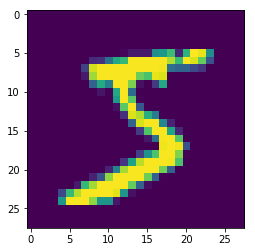

In [9]:

# x_train = x_train.reshape([N, Ni*Nj])
# x_test = x_test.reshape([x_test.shape[0], Ni*Nj])
print("MNIST shape", X_train.shape, X_test.shape)

plt.imshow(X_train[0].reshape([Ni,Nj]))
print(y_train[0])

We define a simple simulation with a single batch. A timeseries of 'stime' timesteps is run. The input is a inpulse 
given in the first timestep consisting of a gaussian noise given to each unit.

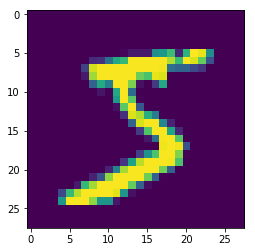

In [11]:
# Global variables

# num_units = 20


# hyperparameters
n_neurons = 128
learning_rate = 0.001
batch_size = 1
n_epochs = 10

# parameters
n_steps = 28 # 28 rows aka Ni
n_inputs = 28 # 28 cols aka Nj
n_outputs = 10 # 10 classes


rnn_inputs = np.zeros((batch_size, n_steps, n_inputs), dtype="float32")
rnn_inputs[:,:,:] = X_train[(0),:,:]
# rnn_inputs[0, :, 0] = np.sin(np.linspace(0,18*np.pi, stime)) + \
#                       np.sin(np.linspace(0,5.3*np.pi, stime)) + \
#                       np.sin(np.linspace(0,2.1*np.pi, stime)) 

plt.imshow(rnn_inputs[0,:,:])
plt.show()
# plt.imshow(rnn_inputs[1,:,:])
# plt.show()

activation = lambda x: math_ops.tanh(x)


Implementing a static graph without tensorflow API:

In [17]:
n_outputs= 10

tf.reset_default_graph()
static_graph = tf.Graph()
with static_graph.as_default() as g:
    
    
    
    
    rng = np.random.RandomState(random_seed)

    # Init the ESN cell
    rnn_init_state = np.zeros([1, n_neurons], dtype="float32")
    cell = EchoStateRNNCell(num_units=n_neurons, 
                            num_inputs=n_inputs,
                            activation=activation, 
                            decay=0.01, 
                            epsilon=1e-10,
                            alpha=0.0100,
                            rng=rng)
    
    inputs = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    init_state = tf.placeholder(tf.float32, [1, n_neurons])
    
    y = tf.placeholder(tf.int32, [None])
    
    # Build the graph
    states = []
    state = init_state
    for t in range(n_steps):
        prev_state = state
        out, state = cell(inputs=inputs[0,t:(t+1),:], state=prev_state)
#         print("out.shape", out.shape)
#         print("state.shape", state.shape)
        states.append(out)
#     states = tf.stack(states)
    
    outputs = tf.reshape(states, [batch_size, n_steps * n_neurons])
    print("outputs.shape", outputs.shape)
    
    logits = tf.layers.dense(outputs, n_outputs)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    prediction = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
    
    
    # initialize the variables
    init = tf.global_variables_initializer()
    
# Run the simulation
#     with tf.Session(config=config) as sess:
#         sess.run(tf.global_variables_initializer())
#         curr_outputs = sess.run([optimizer prediction, accuracy], feed_dict={inputs: rnn_inputs,
#                                                    init_state: rnn_init_state})

        #         plt.plot(np.squeeze(curr_outputs))
      
    

    #         plt.show()
    

('outputs.shape', TensorShape([Dimension(1), Dimension(3584)]))


Implementing a dynamic graph using tensorflow API

In [18]:

# train the model
with tf.Session(graph=static_graph) as sess:
    sess.run(init)
    n_batches = N // batch_size
    for epoch in range(n_epochs):
        permutation = np.random.permutation(N)
        for i, batch in enumerate(range(n_batches)):
            X_batch, y_batch = X_train[permutation[i:i+1]], y_train[permutation[i:i+1]]
            print(X_batch.shape, y_batch.shape)
            X_batch = X_batch.reshape([-1, n_steps, n_inputs])
            _, loss_train, acc_train = sess.run([optimizer, loss, accuracy], feed_dict={inputs: X_train, y: y_train})
        loss_train, acc_train = sess.run(
            [loss, accuracy], feed_dict={X: X_train, y: y_train})
        print('Epoch: {}, Train Loss: {:.3f}, Train Acc: {:.3f}'.format(
            epoch + 1, loss_train, acc_train))
    loss_test, acc_test = sess.run(
        [loss, accuracy], feed_dict={X: X_test, y: y_test})
    print('Test Loss: {:.3f}, Test Acc: {:.3f}'.format(loss_test, acc_test))

((1, 28, 28), (1,))


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [1,128]
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[1,128], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'Placeholder_1', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 1064, in start
    handler_func(fd_obj, events)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-4db56e6c4d3e>", line 23, in <module>
    init_state = tf.placeholder(tf.float32, [1, n_neurons])
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/Users/Austin_Egri/.virtualenvs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [1,128]
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[1,128], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
